In [1]:
import fenics as fn
import numpy as np
from matplotlib import pyplot as plt
#
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
#
from copy import copy, deepcopy
import sys
#

from time import time

**Problem from book: Exact and Approximate Controllability for Distributed Parameter Systems (Glowinski)**

Page 82

diffusion problem:

\begin{equation}
\left\{
\begin{array}{ll}
\displaystyle\frac{\partial y}{\partial t} - \nu\frac{\partial^2 y}{\partial x^2} = v(t)\delta(x - b), & \text{in }(0,1)\times(0,T)\\
y(0,t) = y(1,t) = 0, & \text{on }(0,T)\\
y(0) = 0. &
\end{array}
\right.
\end{equation}

$y_{T}(x) = 4x(1-x)$

**Initial parameters**

In [2]:
#
nu = fn.Constant(1/10)
#
b = 1/2 # np.sqrt(2)/3 # 1/2 # np.pi/6
#
T = 3
#
d_t = 1.e-2
#
h = 1.e-2
#
k = 1.e+4
#
eps = 1.e-6

**Discretization parameters**

In [3]:
Ne = int(1/h)
print('Number of elements:', Ne)
#
Nt = int(T/d_t)
t_vector = np.linspace(0,T,Nt)
print('Number of time steps:',Nt)

Number of elements: 100
Number of time steps: 300


In [4]:
# Boundary condition (x=0 and x=1)
g = fn.Constant(0.0)
# Initial condition forward problem (t=0)
y0 = fn.Expression('0.0', degree=0)
#
v_vector = 1 - t_vector/3

**Forward and backward solvers**

In [5]:
def forward_prob(control,u0):
    #
    u_old = fn.Function(Un)
    u_old.interpolate(u0)
    #
    rhs2 = fn.assemble(fn.Constant(0.0)*vn*(fn.dx))
    delta = fn.PointSource(Un, fn.Point(b), d_t)
    delta.apply(rhs2)
    #
    for idx in range(len(t_vector)):
        ################################################
        rhs1 = fn.assemble(u_old*vn*(fn.dx))  
        bc.apply(rhs1)
        #
        #rhs2 = fn.assemble(fn.Constant(0.0)*vn*(fn.dx))
        #delta = fn.PointSource(Un, fn.Point(b), d_t)
        #delta.apply(rhs2)
        #
        rhs = rhs1[:] + control[idx]*rhs2[:]
        ################################################
        #
        u_new = fn.Function(Un)
        #
        coeff = spsolve(A_matrix_f,rhs)
        u_new.vector()[:] = coeff
        #
        u_old.assign(u_new)    
    return u_new
#
def backward_prob(w0):
    #
    w_old = fn.Function(Un)
    w_old.interpolate(w0)
    #
    control = np.zeros(np.size(t_vector))
    #control[]
    #
    for idx in reversed(range(len(t_vector))):
        #
        ################################################
        rhs1 = fn.assemble(w_old*vn*(fn.dx))  
        bc.apply(rhs1)
        #
        rhs = rhs1[:]
        ################################################
        w_new = fn.Function(Un)
        #
        coeff = spsolve(A_matrix_b,rhs)
        w_new.vector()[:] = coeff
        #
        control[idx] = w_new(b)
        #
        w_old.assign(w_new)      
    return control, w_new

def fenics_copy(v):
    u = fn.Function(Un)
    aux = copy(v.vector()[:])
    u.vector()[:] = aux
    return u

**FEM mesh and spaces**

In [6]:
mesh = fn.IntervalMesh(Ne,0,1)
Un = fn.FunctionSpace(mesh,'CG',1)

**Trial and test functions**

In [7]:
un = fn.TrialFunction(Un)
vn = fn.TestFunction(Un)

**Objetive function**

In [8]:
y_T = fn.Expression('4*x[0]*(1-x[0])', degree = 2)
yn_T = fn.Function(Un)
yn_T.interpolate(y_T)

**Boundary condition**

In [9]:
bc = fn.DirichletBC (Un, g, 'on_boundary')

**Bilinear forms**

In [10]:
bilin_form_f = un*vn*(fn.dx) + fn.Constant(d_t)*nu*fn.dot(fn.grad(un),fn.grad(vn))*(fn.dx)
#
A_fenics = fn.assemble(bilin_form_f)
bc.apply(A_fenics)
#
A_matrix_f = fn.as_backend_type(A_fenics).mat()[:,:]
#
A_matrix_f = sp.csr_matrix(A_matrix_f)
# Backward
bilin_form_b = un*vn*(fn.dx) + fn.Constant(d_t)*nu*fn.dot(fn.grad(un),fn.grad(vn))*(fn.dx)
#
A_fenics = fn.assemble(bilin_form_b)
bc.apply(A_fenics)
#
A_matrix_b = fn.as_backend_type(A_fenics).mat()[:,:]
#
A_matrix_b = sp.csr_matrix(A_matrix_b)

**Algorithm 1.35 from Glowinski - Exact and Approximate Controlability...**

In [11]:
# f0 given in L^{2}(\Omega)
f0 = fn.Function(Un)
#f0.vector()[:] = 1.
f0 = fenics_copy(yn_T)

rate: 0.2494794469240651
keep going


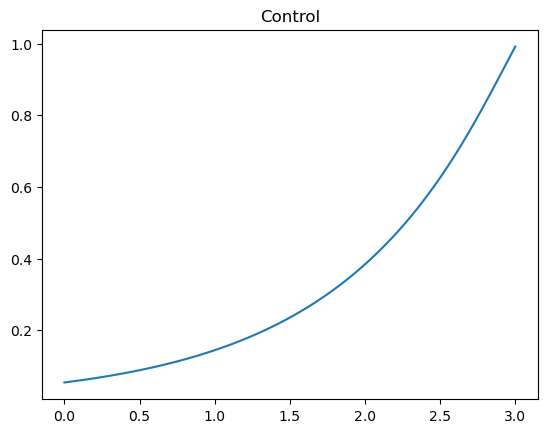

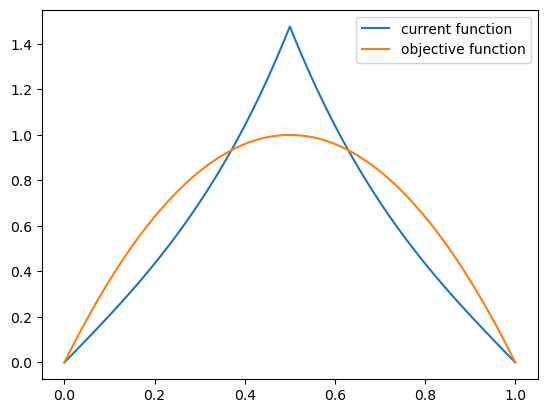

In [12]:
# Solve first the dual
p0,_ = backward_prob(f0)
# and set
u0 = copy(p0)
# Solve now
y0_T = forward_prob(u0,y0)
#
#and compute 
aux = copy( 1/k*f0.vector()[:] + y0_T.vector()[:] - yn_T.vector()[:]) # this way speed up the code!
g0 = fn.Function(Un)
g0.vector()[:] = aux
#
g0_norm = np.sqrt(fn.assemble(g0**2*(fn.dx)))
term_down = np.sqrt(fn.assemble(f0**2*(fn.dx)))
rate = g0_norm/term_down
print('rate:',rate)

if rate < eps:
    print('we are done')
    f_final = f0
    u_final = u0
else:
    print('keep going')
    w0 = g0
    
plt.figure()
plt.plot(t_vector,p0)
plt.title('Control')
plt.figure()
fn.plot(y0_T,label='current function')
fn.plot(yn_T,label='objective function')
plt.legend()
plt.show()    

rho: 6.7715633998101525
keep going!
rate: 1.4944195465367338
-----------------------------------
rho: 1.5423615180220327
keep going!
rate: 0.38929171226785936
-----------------------------------
rho: 59.05299419836437
keep going!
rate: 0.15841244507539298
-----------------------------------
rho: 491.26014132331414
keep going!
rate: 0.0642535862130768
-----------------------------------
rho: 3518.3190690759466
keep going!
rate: 0.017609156517847686
-----------------------------------
rho: 7936.700793328327
keep going!
rate: 0.0007823612401618566
-----------------------------------
rho: 866.1787677180229
keep going!
rate: 0.02260954726238713
-----------------------------------
rho: 10.542732117985583
keep going!
rate: 6.815577078243797e-06
-----------------------------------
rho: 9.874999975290233
keep going!
rate: 2.343462810302127e-06
-----------------------------------
rho: 8923.708105856007
we are done!


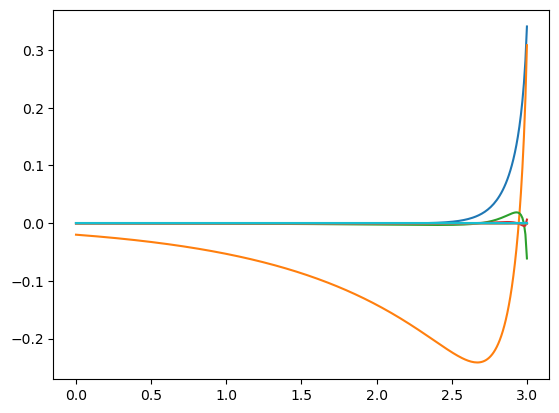

In [13]:
# Then for n > 0, assuming that fk, gk, and wk are known, compute f{k+1}, g{k+1}, w{k+1} as folow
f_old = fenics_copy(f0) 
g_old = fenics_copy(g0)
w_old = fenics_copy(g0)
#
for iteration in range(12):
    # dual
    p_bar,_ = backward_prob(w_old)
    u_bar = copy(p_bar) # (control)
    # primal
    plt.plot(t_vector,u_bar)
    y_bar = forward_prob(u_bar,fn.Expression('0,0',degree=0)) # here it should be 0 instead of y0, but y0 already is cero!
    # and compute
    aux = copy((1/k)*w_old.vector()[:] + y_bar.vector()[:]) # speed ups!
    g_bar = fn.Function(Un)
    g_bar.vector()[:] = aux
    #
    rho_up = fn.assemble(g_old**2*(fn.dx))
    rho_down = fn.assemble(g_bar*w_old*(fn.dx))
    rho = rho_up/rho_down
    print('rho:',rho)
    # Updates
    f_new = fn.Function(Un)
    g_new = fn.Function(Un)
    #
    aux = copy(f_old.vector()[:] - rho*w_old.vector()[:])           
    f_new.vector()[:] = aux
    #      
    aux = copy(g_old.vector()[:] - rho*g_bar.vector()[:])           
    g_new.vector()[:] = aux
    # Stopping criteria (falta un criterio de parada aquí)
    
    #
    gamma_up   = fn.assemble(g_new**2*(fn.dx))
    gamma_down = fn.assemble(g_old**2*(fn.dx))
    gamma = gamma_up/gamma_down
    #
    rate = np.sqrt(gamma_up)/g0_norm
    if rate < eps:
        f_final = fenics_copy(f_new)
        print('we are done!')
        break
    else:
        w_new = fn.Function(Un)
        aux = copy(g_new.vector()[:] + gamma*w_old.vector()[:])
        w_new.vector()[:] = aux
        print('keep going!')
    print('rate:',rate)
    print('-----------------------------------')
    #
    # Update
    f_old = fenics_copy(f_new)
    g_old = fenics_copy(g_new)
    w_old = fenics_copy(w_new)

In [14]:
p_bar,_ = backward_prob(f_final)
y_bar = forward_prob(p_bar,fn.Expression('0,0',degree=0))

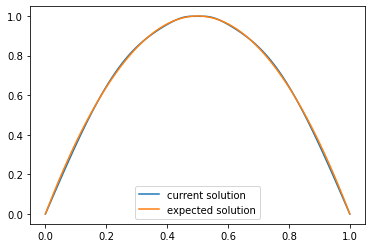

In [15]:
fn.plot(y_bar,label='current solution')
fn.plot(yn_T,label='expected solution')
plt.legend()
plt.show()

In [16]:
error = np.sqrt(fn.assemble((y_bar - yn_T)**2*(fn.dx))/fn.assemble(yn_T**2*(fn.dx)))
print(format(error, ".1e"))

9.2e-03


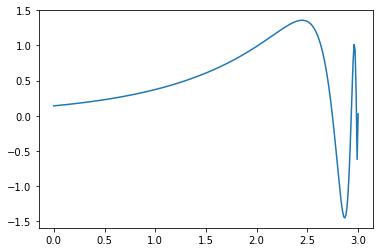

In [17]:
plt.plot(t_vector,p_bar)
plt.show()